In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
PRIMATE_DATA = 'milk.csv'
DATA_FOLDER = '../../data'

In [3]:
df = pd.read_csv(f'{DATA_FOLDER}/{PRIMATE_DATA}')
df.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


## Explanation of Columns

* kcal.per.g = kcal per gram of milk
* mass = average female body mass in kg
* neocortex.perc = percentage of total brain mass that is neocortex

In [5]:
df = df.dropna()

## Standardlize Variables

### Code 5.28

In [6]:
df['kcal.per.g_stan'] = (df['kcal.per.g'] - df['kcal.per.g'].mean()) / df['kcal.per.g'].std()
df['mass_stan'] = (df['mass'] - df['mass'].mean()) / df['mass'].std()
df['neocortex.perc_log'] = df['neocortex.perc'].apply(np.log)
df['neocortex.perc_stan'] = (df['neocortex.perc_log'] - df['neocortex.perc_log'].mean()) /  df['neocortex.perc_log'].std()

## First Model

In this model, we regress the kilocalaries per gram with the neocortex mass. 
$$
\begin{align*}
    K_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_N \cdot N_i \\
    \alpha  & \sim N(0, 1) \\
    \beta_N & \sim N(0, 1) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [7]:
with pm.Model() as m_5_5_draft:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_N = pm.Normal('beta_N', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_N * df['mass_stan'])
    K = pm.Normal('kilocal', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_5_draft = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 13 seconds.


## Prior Predictive Plots

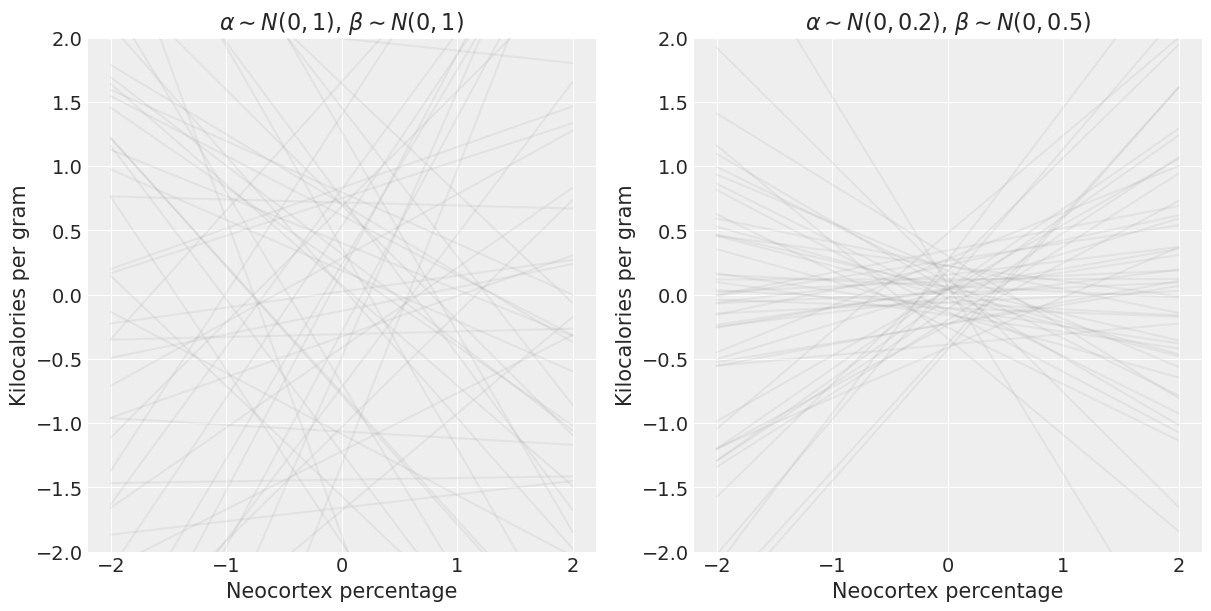

In [8]:
from scipy.stats import norm


N = 50

xvals = np.linspace(-2, 2, num=100)
a_1 = norm.rvs(loc=0, scale=1, size=N)
b_1 = norm.rvs(loc=0, scale=1, size=N)

a_2 = norm.rvs(loc=0, scale=0.2, size=N)
b_2 = norm.rvs(loc=0, scale=0.5, size=N)

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(12, 6))

for i in range(N):
    line_1 = a_1[i] + b_1[i] * xvals
    line_2 = a_2[i] + b_2[i] * xvals
    
    ax_1.plot(xvals, line_1, color='grey', alpha=0.1)
    ax_2.plot(xvals, line_2, color='grey', alpha=0.1)
    
ax_1.set_xlabel('Neocortex percentage')
ax_1.set_ylabel('Kilocalories per gram')
ax_1.set_ylim(-2, 2)

ax_2.set_xlabel('Neocortex percentage')
ax_2.set_ylabel('Kilocalories per gram')
ax_2.set_ylim(-2, 2)

ax_1.set_title(r'$\alpha \sim N(0,1)$, $\beta \sim N(0, 1)$')
ax_2.set_title(r'$\alpha \sim N(0,0.2)$, $\beta \sim N(0, 0.5)$')

plt.show()